In [1]:
cd /home

/home


In [56]:
import matplotlib.pyplot as plt

from src.models.astromer_0 import get_ASTROMER 
from src.data.zero import pretraining_pipeline

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [9]:
probed = 0.9
random = 0.
same   = 0.
window_size = 200

loader = pretraining_pipeline('./data/records/alcock/fold_0/alcock_20/train/',
                              batch_size= 32, 
                              window_size=window_size,
                              shuffle=True,
                              sampling=True,
                              repeat=1,
                              msk_frac=probed,
                              rnd_frac=random,
                              same_frac=same)

[INFO] Sampling random windows


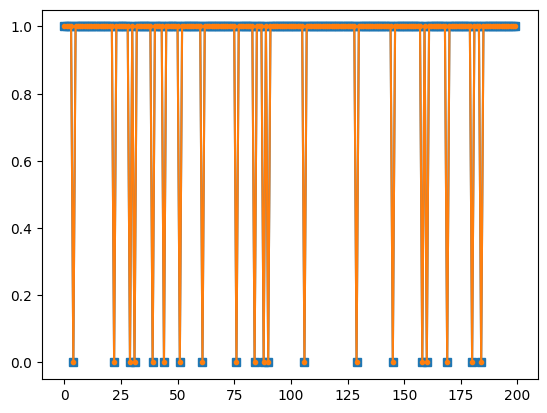

In [21]:
plt.figure()
for x, y in loader.take(1):
    x_input = x['input'][0]
    x_times = x['times'][0]
    x_maski = x['mask_in'][0]
    x_masko = y['mask_out'][0]
    
    cond = x_maski == x_masko
    
    plt.plot(x_maski, label='in', marker='s')
    plt.plot(x_masko, label='out', marker='.')

In [75]:
import tensorflow as tf 

from src.models.astromer_0 import positional_encoding
from src.models.astromer_0 import MultiHeadAttention 

from tensorflow.keras.layers import Dense, TimeDistributed, Dropout

In [51]:
for x, y in loader.take(1):
    # Input Transformer + PE
    x_pe = positional_encoding(x['times'], 256, mjd=True)
    x_transformed = Dense(256)(x['input'])
    transformed_input = x_transformed + x_pe
    transformed_input = Dropout(0.)(transformed_input)
    
    # Encoder layer 
    
    attn_output, w, qkvalues = MultiHeadAttention(256, 4, -1000000, 'QK')(transformed_input, mask=x['mask_in'])
    
    

[INFO] Using PE with c: 2.0
[INFO] Using masked-att with alpha = -1000000.00
[INFO] Masking Query and Key tokens


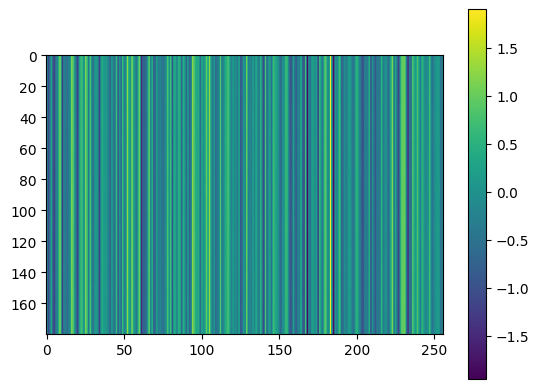

In [86]:
att_mask = tf.boolean_mask(attn_output[0], x['mask_in'][0,...,0])

plt.imshow(att_mask)
plt.colorbar()

Text(0.5, 1.0, 'S(QK - $\\infty$M)*V')

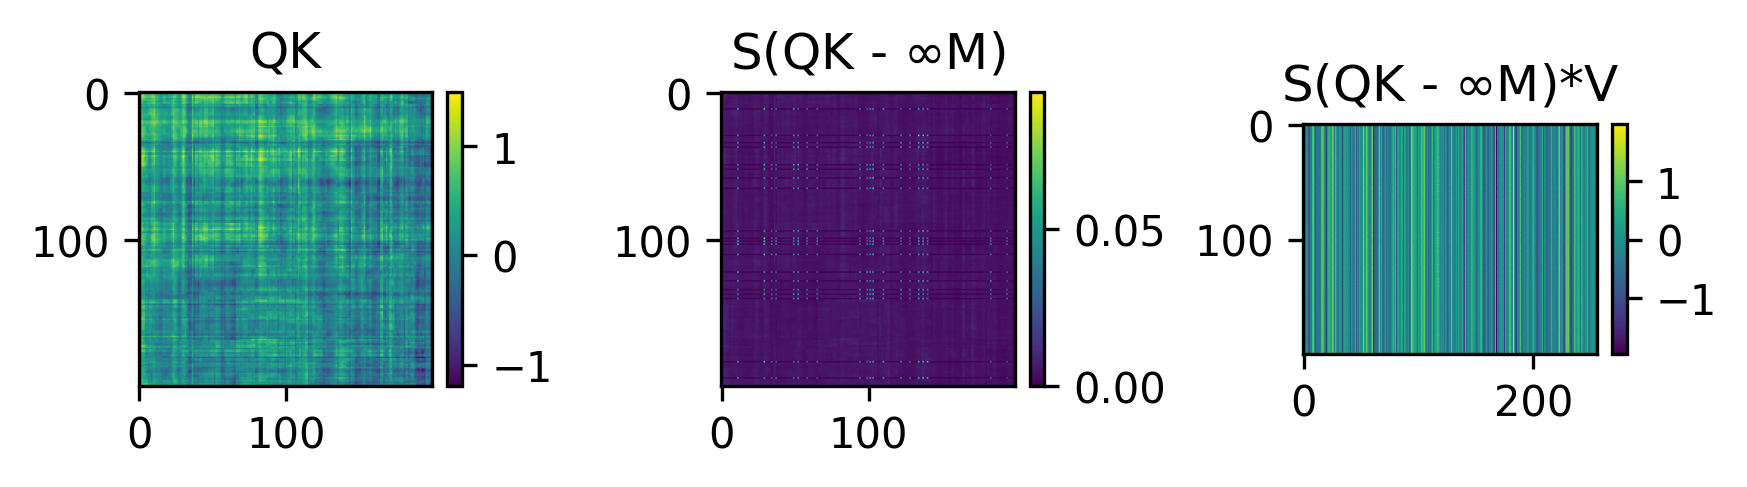

In [73]:
fig, axes = plt.subplots(1, 3, gridspec_kw={'wspace':0.8}, dpi=300)
im0 = axes[0].imshow(qkvalues[0, 0])
im1 = axes[1].imshow(w[0, 0])
im2 = axes[2].imshow(attn_output[0])

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

axes[0].set_title('QK')
axes[1].set_title(r'S(QK - $\infty$M)')
axes[2].set_title('S(QK - $\infty$M)*V')